In [102]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

In [103]:
df = pd.read_csv('df_with_emotions.csv')

In [104]:
df.head()

,Age,Gender,GPA,Stress_Level,Anxiety_Score,Depression_Score,Daily_Reflections,Sleep_Hours,Steps_Per_Day,Mental_Health_Status,fear,anger,anticipation,trust,surprise,sadness,joy,disgust,negative,positive
0,1.159999,2,-0.566791,5,20,6,Onto foreign do environmental anyone every nea...,0.483148,-0.963883,2,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,1.000000,0.000000
1,-0.601579,1,-0.138201,5,3,7,Party but others visit admit industry country ...,-0.633426,-0.566872,2,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,0.000000,1.000000
2,0.279210,0,1.400826,5,11,24,Religious sure wait do chance decade according...,1.468360,0.793510,2,-0.589006,-0.403906,0.977859,-0.959785,2.005550,-0.401565,-0.739343,0.000000,0.250000,0.250000
3,-1.041973,1,-1.501896,4,15,14,A task effect entire coach join series.,1.402679,-0.263157,2,-0.589006,-0.403906,-0.754115,1.588991,-0.409189,-0.401565,-0.739343,0.000000,0.000000,0.500000
4,-0.601579,2,0.115057,1,2,4,Knowledge several camera wait week write quali...,-0.107979,-1.201176,0,-0.589006,0.271686,0.311715,-0.175546,0.333807,-0.401565,0.895866,0.076923,0.153846,0.153846


In [105]:
X = df.drop(columns=['Mental_Health_Status', 'Daily_Reflections', 'Stress_Level', 'Depression_Score', 'Anxiety_Score'])
Y = df['Mental_Health_Status']
X.head()

,Age,Gender,GPA,Sleep_Hours,Steps_Per_Day,fear,anger,anticipation,trust,surprise,sadness,joy,disgust,negative,positive
0,1.159999,2,-0.566791,0.483148,-0.963883,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,1.000000,0.000000
1,-0.601579,1,-0.138201,-0.633426,-0.566872,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,0.000000,1.000000
2,0.279210,0,1.400826,1.468360,0.793510,-0.589006,-0.403906,0.977859,-0.959785,2.005550,-0.401565,-0.739343,0.000000,0.250000,0.250000
3,-1.041973,1,-1.501896,1.402679,-0.263157,-0.589006,-0.403906,-0.754115,1.588991,-0.409189,-0.401565,-0.739343,0.000000,0.000000,0.500000
4,-0.601579,2,0.115057,-0.107979,-1.201176,-0.589006,0.271686,0.311715,-0.175546,0.333807,-0.401565,0.895866,0.076923,0.153846,0.153846


In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [107]:
model = XGBClassifier(objective="multi:softmax", num_class=3, random_state=42)
param_grid = {
    'n_estimators': [1, 3, 5, 10],
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [3, 5],
}

In [108]:
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [109]:
best_params_list = []
test_scores = []

In [110]:
for train_idx, test_idx in outer_cv.split(X, Y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    grid = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=inner_cv)
    grid.fit(X_train, y_train)

    best_params_list.append(grid.best_params_)

    test_score = grid.score(X_test, y_test)
    test_scores.append(test_score)

In [111]:
print("Test scores per fold:", test_scores)
print("Average nested CV score:", np.mean(test_scores))

param_counter = Counter(tuple(sorted(bp.items())) for bp in best_params_list)
most_common = param_counter.most_common(1)[0]

print("\nMost common best hyperparameters across folds:")
for param, value in most_common[0]:
    print(f"  {param}: {value}")
print(f"Selected in {most_common[1]} out of {len(best_params_list)} folds")

Test scores per fold: [0.61, 0.64, 0.68, 0.66, 0.68]
Average nested CV score: 0.6540000000000001

Most common best hyperparameters across folds:
  learning_rate: 0.5
  max_depth: 3
  n_estimators: 3
Selected in 2 out of 5 folds


In [112]:
model = XGBClassifier(objective="multi:softmax", num_class=3, random_state=42, learning_rate=0.5, max_depth=3, n_estimators=3)

In [113]:
model.fit(X_train, y_train)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [114]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.68


In [115]:
f1 = f1_score(y_test, y_pred, average='macro')
print("Macro-Averaged F1 Score:", f1)

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

class_labels = sorted(y_test.unique())  # e.g., [0, 1, 2]

print("\nPrecision and Recall by Class:")
for i, label in enumerate(class_labels):
    print(f"Class {label}: Precision = {precision[i]:.3f}, Recall = {recall[i]:.3f}")

Macro-Averaged F1 Score: 0.29129852744310575

Precision and Recall by Class:
Class 0: Precision = 0.000, Recall = 0.000
Class 1: Precision = 0.500, Recall = 0.036
Class 2: Precision = 0.684, Recall = 0.985


/Users/Aysha/PycharmProjects/AI4ALL-Ignite-SU25/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Confusion Matrix: XGBoost


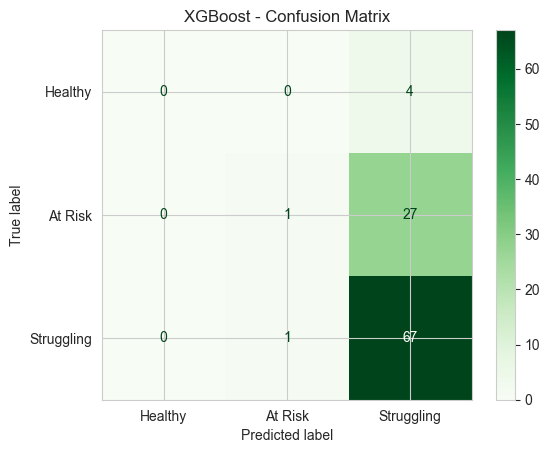

In [116]:
#Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
                                  display_labels=['Healthy', 'At Risk', 'Struggling'])
print("Confusion Matrix: XGBoost")
disp_xgb.plot(cmap='Greens')
plt.title("XGBoost - Confusion Matrix")
plt.show()

In [117]:
import joblib
joblib.dump(model, 'XGBoost_model.pkl')

['XGBoost_model.pkl']

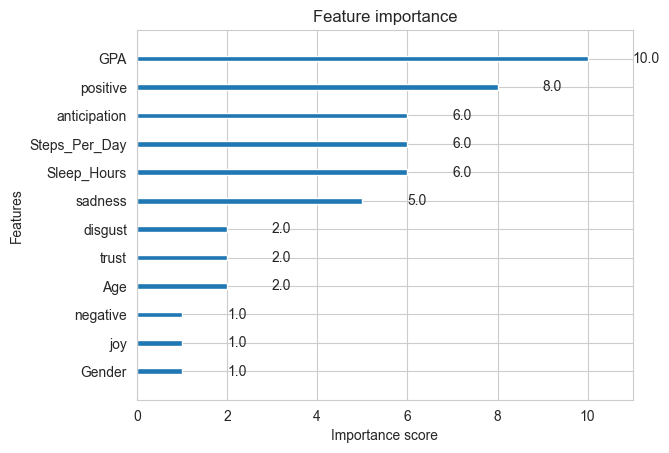

In [118]:
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.show()